In [1]:
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

data = pd.read_csv('gender_labels.csv')

image_paths = data['file_path'].values
labels = data['label'].values

label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

train_paths, val_paths, train_labels, val_labels = train_test_split(image_paths, labels, test_size=0.2, random_state=42)


def load_and_preprocess_image(image_path, augment=False):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])  
    image = image / 255.0  
    
    if augment:
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_brightness(image, max_delta=0.2)
        image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
        image = tf.image.random_saturation(image, lower=0.8, upper=1.2)
        image = tf.image.random_hue(image, max_delta=0.02)
        
    return image

def create_dataset(paths, labels, is_train=False):
    path_ds = tf.data.Dataset.from_tensor_slices(paths)
    image_ds = path_ds.map(lambda path: load_and_preprocess_image(path, augment=is_train), num_parallel_calls=tf.data.AUTOTUNE)
    label_ds = tf.data.Dataset.from_tensor_slices(labels)
    return tf.data.Dataset.zip((image_ds, label_ds))

train_dataset = create_dataset(train_paths, train_labels, is_train=True).batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = create_dataset(val_paths, val_labels).batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)


In [50]:
def create_transfer_learning_model():
    base_model = VGG16(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
    base_model.trainable = False  
    
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])
    
    return model

model = create_transfer_learning_model()

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset)

base_model = model.layers[0]
base_model.trainable = True
for layer in base_model.layers[:-4]:
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])


history_fine = model.fit(train_dataset,
                         epochs=10,
                         validation_data=val_dataset)

model.save('gender_classification_model_vgg16.keras')


Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 115s 2s/step - accuracy: 0.6986 - loss: 0.6203 - val_accuracy: 0.7950 - val_loss: 0.4252
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 202s 4s/step - accuracy: 0.7770 - loss: 0.4803 - val_accuracy: 0.8200 - val_loss: 0.3716
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 117s 2s/step - accuracy: 0.7994 - loss: 0.4390 - val_accuracy: 0.8300 - val_loss: 0.3506
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 124s 2s/step - accuracy: 0.8163 - loss: 0.4154 - val_accuracy: 0.8525 - val_loss: 0.3328
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 120s 2s/step - accuracy: 0.8239 - loss: 0.3963 - val_accuracy: 0.8675 - val_loss: 0.3240
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 125s 3s/step - accuracy: 0.8348 - loss: 0.3860 - val_accuracy: 0.8800 - val_loss: 0.3113
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 119s 2s/step - accuracy: 0.8451 - loss: 0.3699 - val_accuracy: 0.8850 - val_loss: 0.3064
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 117s 2s/step - accuracy: 0.8386 - loss: 0.3684 - val_accuracy: 0.8825 - v

In [2]:

from tensorflow.keras.models import load_model

loaded_model = load_model('gender_classification_model_vgg16.keras')

In [3]:
val_loss, val_acc = loaded_model.evaluate(val_dataset)
print(f'Validation accuracy of loaded model: {val_acc:.2f}')

13/13 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.9273 - loss: 0.2178
Validation accuracy of loaded model: 0.92


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
Predicted class: Female


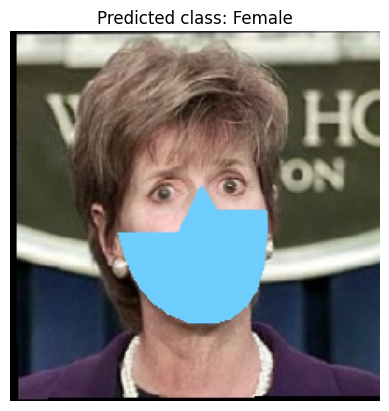

In [4]:

def preprocess_image(image_path):
    img = image.load_img(image_path, target_size=(224, 224))  
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.vgg16.preprocess_input(img_array)
    return img_array


import random
random_index = random.randint(0, len(image_paths) - 1)
new_image_path = image_paths[random_index]


preprocessed_img = preprocess_image(new_image_path)


prediction = loaded_model.predict(preprocessed_img)
predicted_class = 'Female' if prediction[0] < 0.5 else 'Male'

print(f"Predicted class: {predicted_class}")


img = image.load_img(new_image_path, target_size=(224, 224))
plt.imshow(img)
plt.title(f"Predicted class: {predicted_class}")
plt.axis('off')
plt.show()